In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt 
import numpy as np
import os 
import PIL
from tensorflow.keras import layers 
import pandas as pd
import seaborn as sns
import pickle 
import zipfile
tf.__version__

'2.8.2'

In [18]:
import random

**Carregamento Base de Dados**

In [3]:
from google.colab import drive
drive.mount('/drive/')

Mounted at /drive/


In [9]:
path = "/content/drive/traffic-signs-data.zip"
zip_object = zipfile.ZipFile(file=path, mode="r")
zip_object.extractall("./")
zip_object.close()

In [12]:
with open("traffic-signs-data/train.p", mode='rb') as training_data:
  train = pickle.load(training_data)
with open("traffic-signs-data/valid.p", mode='rb') as validation_data:
  valid = pickle.load(validation_data)
with open("traffic-signs-data/test.p", mode='rb') as testing_data:
  test = pickle.load(testing_data)

In [13]:
X_train, y_train = train['features'], train['labels']
X_validation, y_validation = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

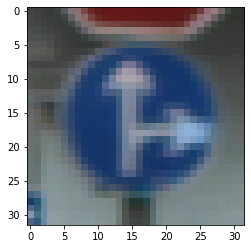

In [14]:
plt.imshow(X_train[1100])

**Visualização dos dados**

In [15]:
X_train.shape

(34799, 32, 32, 3)

In [16]:
X_test.shape

(12630, 32, 32, 3)

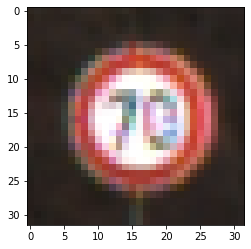

In [19]:
i = random.randint(1, 34000)
plt.imshow(X_train[i], cmap = 'gray')

In [20]:
label = y_train[i]
label

4

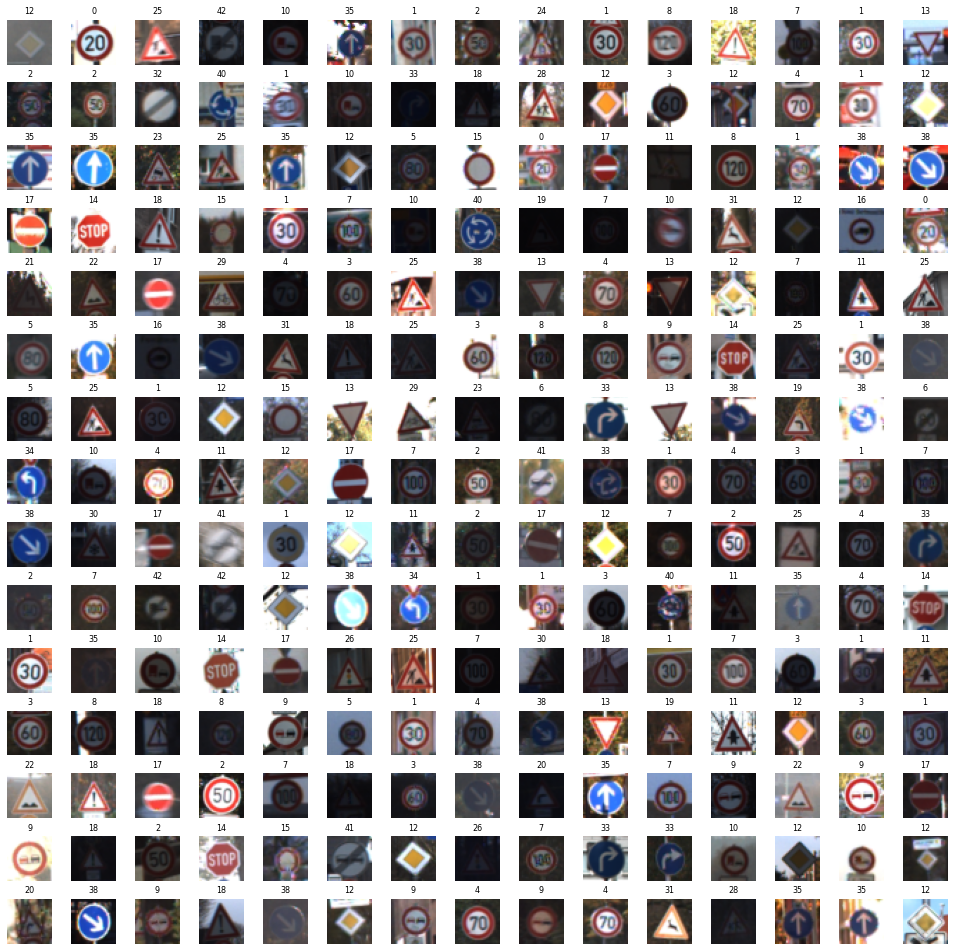

In [21]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17, 17))

axes = axes.ravel()
n_training = len(X_train)

for i in np.arange(0, W_grid * L_grid):
  index = np.random.randint(0, n_training)
  axes[i].imshow(X_train[index])
  axes[i].set_title(y_train[index], fontsize = 8)
  axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

**Pré-processamento**

In [22]:
X_train = X_train / 255
X_test = X_test / 255

Criação e treinamento do autoencoder

In [24]:
autoencoder = tf.keras.models.Sequential()

#Encoder
autoencoder.add(tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same', input_shape=(32, 32, 3)))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Activation('relu'))
autoencoder.add(tf.keras.layers.AveragePooling2D((2,2), padding='same'))

autoencoder.add(tf.keras.layers.Conv2D(32, (3,3), strides=1, padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Activation('relu'))
autoencoder.add(tf.keras.layers.AveragePooling2D((2,2), padding='same'))

autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Activation('relu'))

#Encoded image (Code Layer)
autoencoder.add(tf.keras.layers.AveragePooling2D((2,2), padding='same')) 

#Decoder 
autoencoder.add(tf.keras.layers.Conv2D(16, (3,3), strides=1, padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Activation('relu'))
autoencoder.add(tf.keras.layers.UpSampling2D((2,2))) 

autoencoder.add(tf.keras.layers.Conv2D(32, (3,3), strides=1, padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Activation('relu'))
autoencoder.add(tf.keras.layers.UpSampling2D((2,2))) 

autoencoder.add(tf.keras.layers.Conv2D(64, (3,3), strides=1, padding='same'))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(tf.keras.layers.Activation('relu'))
autoencoder.add(tf.keras.layers.UpSampling2D((2,2))) 

autoencoder.add(tf.keras.layers.Conv2D(3, (3,3), strides=1, activation='sigmoid', padding='same'))

In [25]:
autoencoder.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.01))
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 average_pooling2d (AverageP  (None, 16, 16, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
X_train.shape

(34799, 32, 32, 3)

In [27]:
X_test.shape

(12630, 32, 32, 3)

In [29]:
autoencoder.fit(X_train, 
                X_train,
                epochs=5, 
                batch_size=200,
                validation_data= (X_test, X_test))

Epoch 1/5
174/174 [==============================] - 269s 2s/step - loss: 0.4828 - val_loss: 0.4803
Epoch 2/5
174/174 [==============================] - 268s 2s/step - loss: 0.4801 - val_loss: 0.4771
Epoch 3/5
174/174 [==============================] - 268s 2s/step - loss: 0.4785 - val_loss: 0.4817
Epoch 4/5
174/174 [==============================] - 266s 2s/step - loss: 0.4759 - val_loss: 0.4759
Epoch 5/5
174/174 [==============================] - 268s 2s/step - loss: 0.4748 - val_loss: 0.4717


In [30]:
predicted = autoencoder.predict(X_test[:10].reshape(-1, 32, 32, 3))

In [31]:
predicted.shape

(10, 32, 32, 3)

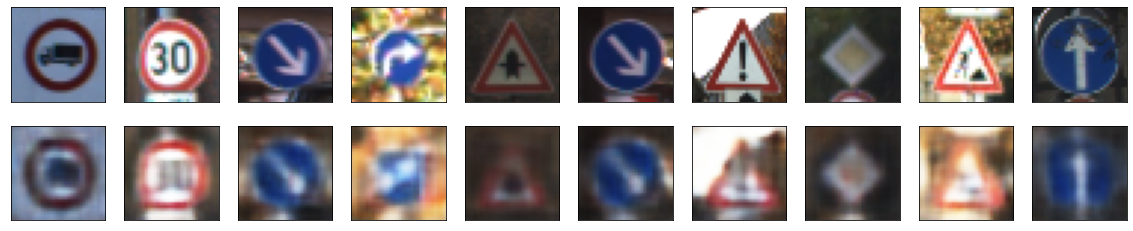

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([X_test[:10], predicted], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((32, 32, 3)))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)